In [ ]:
# https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
import keras

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras import Sequential

from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Precision, Recall, Accuracy
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [52]:
nltk.download('stopwords')
nltk.download('wordnet')
STOPWORDS = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [53]:
tweets = pd.read_csv("./twitter_training.csv")
tweets.head()

,id,name,label,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


### Cleaning and remove unusable data from DataFrame

In [54]:
tweets.drop(["id", "name"], axis=1, inplace=True)

In [55]:
tweets.head()

,label,text
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


In [56]:
tweets["label"] = np.where(tweets["label"] == "Positive", 1, 0) # twitter returned 4 as positive

### Data Analysis

In [57]:
tweets["label"].unique()

array([1, 0])

In [58]:
tweets["label"].value_counts()

,count
label,
0,53850
1,20832


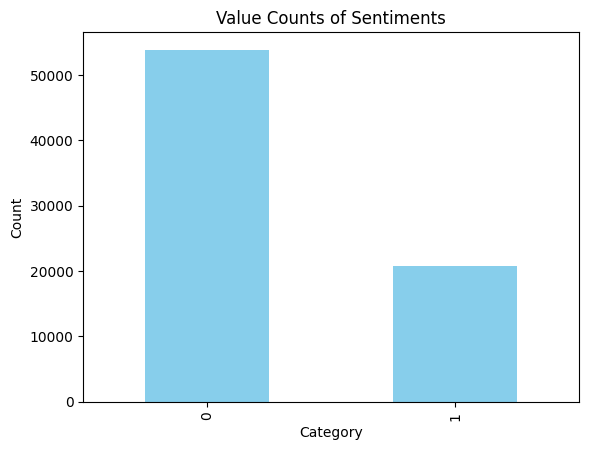

In [59]:
counts = tweets['label'].value_counts()

counts.plot(kind='bar', color='skyblue')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Value Counts of Sentiments')
plt.show()

### Pre processing

In [60]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   74682 non-null  int64 
 1   text    73996 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [61]:
# dataframe para treinamento do embedding do tensorflow
df_tensorflow = tweets.copy()

In [62]:
df_tensorflow["text"] = df_tensorflow["text"].astype(str)

In [63]:
lemmatizer = WordNetLemmatizer()

def pre_process(text):
    text = re.sub(r'http\S+', '', text) # remove links from text
    text = re.sub(r'@\S+', '', text) # remove mentions from text
    text = re.sub(r'[^A-Za-z]+', ' ', text) # Keep only letters (remove numbers and special characters)
    text = [lemmatizer.lemmatize(word) for word in text.split() if word not in STOPWORDS] # remove stop words and lemmatize the words
    text = " ".join(text)

    return text.lower().strip()

In [64]:
df_tensorflow["text"] = df_tensorflow["text"].apply(pre_process)

In [65]:
df_tensorflow.head()

,label,text
0,1,im getting borderland murder
1,1,i coming border i kill
2,1,im getting borderland kill
3,1,im coming borderland murder
4,1,im getting borderland murder


### Padronize Data

In [66]:
max_features = 10000

word_tokenizer = Tokenizer(
    oov_token="<OOV>",
    lower=True,
    num_words=max_features,
)

In [67]:
word_tokenizer.fit_on_texts(df_tensorflow["text"])

In [ ]:
word_tokenizer.word_index

In [69]:
len(word_tokenizer.word_index)

27911

In [70]:
X_sequences = word_tokenizer.texts_to_sequences(df_tensorflow["text"])

In [86]:
X_padded = pad_sequences(X_sequences, padding="post", truncating="post", maxlen=100) # preenche os arrays com 0 na esquerda para todos ficarem com mesmo tamanho

### Split data

In [114]:
X_train, y_train = X_padded, df_tensorflow["label"]

In [120]:
df_val = pd.read_csv("twitter_validation.csv")
df_val.drop(["id", "name"], axis=1, inplace=True)
df_val["label"] = np.where(df_val["label"] == "Positive", 1, 0) # twitter returned 4 as positive

df_val["text"] = df_val["text"].apply(pre_process)

X_val_sequences = word_tokenizer.texts_to_sequences(df_val["text"])
X_val_padded = pad_sequences(X_val_sequences, padding="post", truncating="post", maxlen=100)
y_val = df_val["label"]

### Build LSTM Model

In [87]:
max_features = len(word_tokenizer.word_index) + 1
output_dim = 64

In [112]:
model = Sequential([
    Embedding(input_dim=max_features, output_dim=output_dim),
    LSTM(64, return_sequences=True),
    tf.keras.layers.GlobalAveragePooling1D(),
    Dropout(0.5),
    Dense(24, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [113]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [118]:
model.fit(X_train, y_train, epochs=20)

Epoch 1/20
2334/2334 [==============================] - 114s 48ms/step - loss: 0.5263 - accuracy: 0.7328
Epoch 2/20
2334/2334 [==============================] - 111s 48ms/step - loss: 0.4990 - accuracy: 0.7435
Epoch 3/20
2334/2334 [==============================] - 111s 47ms/step - loss: 0.3368 - accuracy: 0.8492
Epoch 4/20
2334/2334 [==============================] - 111s 47ms/step - loss: 0.2361 - accuracy: 0.9038
Epoch 5/20
2334/2334 [==============================] - 111s 48ms/step - loss: 0.1803 - accuracy: 0.9289
Epoch 6/20
2334/2334 [==============================] - 111s 47ms/step - loss: 0.1520 - accuracy: 0.9407
Epoch 7/20
2334/2334 [==============================] - 110s 47ms/step - loss: 0.1244 - accuracy: 0.9505
Epoch 8/20
2334/2334 [==============================] - 110s 47ms/step - loss: 0.1081 - accuracy: 0.9575
Epoch 9/20
2334/2334 [==============================] - 110s 47ms/step - loss: 0.0961 - accuracy: 0.9617
Epoch 10/20
2334/2334 [==============================] 

In [122]:
loss, acc = model.evaluate(X_val_padded, y_val)

32/32 [==============================] - 1s 16ms/step - loss: 0.1769 - accuracy: 0.9720


In [123]:
print(f"Model Loss: {loss}\nModel Accuracy: {acc}")

Model Loss: 0.17687495052814484
Model Accuracy: 0.972000002861023


### Build Simple Model

In [124]:
model = Sequential([
    Embedding(input_dim=max_features, output_dim=output_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation="relu"),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [125]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [126]:
model.fit(X_train, y_train, epochs=20)

Epoch 1/20
2334/2334 [==============================] - 27s 11ms/step - loss: 0.4827 - accuracy: 0.7718
Epoch 2/20
2334/2334 [==============================] - 27s 11ms/step - loss: 0.3431 - accuracy: 0.8487
Epoch 3/20
2334/2334 [==============================] - 27s 12ms/step - loss: 0.2935 - accuracy: 0.8724
Epoch 4/20
2334/2334 [==============================] - 27s 12ms/step - loss: 0.2664 - accuracy: 0.8847
Epoch 5/20
2334/2334 [==============================] - 27s 11ms/step - loss: 0.2501 - accuracy: 0.8936
Epoch 6/20
2334/2334 [==============================] - 27s 12ms/step - loss: 0.2406 - accuracy: 0.8962
Epoch 7/20
2334/2334 [==============================] - 28s 12ms/step - loss: 0.2314 - accuracy: 0.9003
Epoch 8/20
2334/2334 [==============================] - 27s 12ms/step - loss: 0.2239 - accuracy: 0.9045
Epoch 9/20
2334/2334 [==============================] - 27s 11ms/step - loss: 0.2157 - accuracy: 0.9070
Epoch 10/20
2334/2334 [==============================] - 27s 12m

In [127]:
loss, acc = model.evaluate(X_val_padded, y_val)

32/32 [==============================] - 0s 2ms/step - loss: 0.1456 - accuracy: 0.9590


In [128]:
print(f"Model Loss: {loss}\nModel Accuracy: {acc}")

Model Loss: 0.14564618468284607
Model Accuracy: 0.9589999914169312
